# HTML: feature engineering and model training
In this notebook, we focus on getting the data and properly shaping it to extract meaningful features for the model.
Then, we engineer some features that we hope will make the model capture the patterns better.
Finally, we fine tune the hyperparameters and perform model selection to find the best performing model.

## Setup the environment

In [53]:
# Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from workalendar.europe import Finland
import seaborn as sns
import pickle
import joblib
import plotly.express as px

# Import the helper file methods
from helper_file import load_data, get_file_paths, plotCoefficients, plotModelResults
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the data

In [2]:
url = 'https://aineistot.vayla.fi/lam/reports/LAM/'
result = get_file_paths(url)

In [3]:
dfs = []
for url in result:
    d = load_data(url)
    dfs.append(d)
data_set = pd.concat(dfs, ignore_index=True)

In [4]:
data_set.head()

,TMS,Location,Date,Direction,Type,00-01,01-02,02-03,03-04,04-05,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00
0,117,vt1_Munkkiniemi,2019-01-12,1,11 HA-PA,216,186,158,147,117,...,976,974,978,899,829,675,525,362,189,108
1,117,vt1_Munkkiniemi,2019-01-12,1,12 KAIP,0,2,0,1,0,...,5,2,2,4,2,4,1,0,0,0
2,117,vt1_Munkkiniemi,2019-01-12,1,13 Linja-autot,1,2,1,0,2,...,15,8,12,8,11,9,8,5,6,4
3,117,vt1_Munkkiniemi,2019-01-12,1,14 KAPP,1,0,0,0,0,...,0,0,0,0,1,1,1,0,1,1
4,117,vt1_Munkkiniemi,2019-01-12,1,15 KATP,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


## Preprocessing and Feature Extraction

In [5]:
cal = Finland()
data_set['holiday'] = data_set.Date.apply(lambda x: not cal.is_working_day(x))

In [6]:
id_vars=list(data_set.columns[:5])
id_vars.append(data_set.columns[-1])
value_vars=list(data_set.columns[5:][:-1])
data_set = pd.melt(data_set, id_vars=id_vars, value_vars=value_vars)

In [7]:
data_set.drop_duplicates(['Date', 'variable', 'Direction', 'Type'], inplace = True)
data_set.head()

,TMS,Location,Date,Direction,Type,holiday,variable,value
0,117,vt1_Munkkiniemi,2019-01-12,1,11 HA-PA,True,00-01,216
1,117,vt1_Munkkiniemi,2019-01-12,1,12 KAIP,True,00-01,0
2,117,vt1_Munkkiniemi,2019-01-12,1,13 Linja-autot,True,00-01,1
3,117,vt1_Munkkiniemi,2019-01-12,1,14 KAPP,True,00-01,1
4,117,vt1_Munkkiniemi,2019-01-12,1,15 KATP,True,00-01,0


In [8]:
car_total = data_set.groupby(['Date', 'Direction', 'variable'])
data = car_total[['value', 'holiday']].sum().reset_index()

In [9]:
conve_dict = dict(zip(data.variable.unique(), list(range(24))))
data.head()

,Date,Direction,variable,value,holiday
0,2019-01-12,1,00-01,218,7
1,2019-01-12,1,01-02,190,7
2,2019-01-12,1,02-03,159,7
3,2019-01-12,1,03-04,148,7
4,2019-01-12,1,04-05,119,7


In [10]:
data.variable = data.variable.transform(lambda x: conve_dict[x])
data.holiday = data.holiday.astype(bool)*1

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
#data['Date']= data['Date'].map(dt.datetime.toordinal)
data['timestamp'] = data['Date'] + data.variable.apply(lambda x: np.timedelta64(x, 'h'))

In [12]:
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data['week'] = pd.DatetimeIndex(data['Date']).week
data['weekday'] = pd.DatetimeIndex(data['Date']).weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data['day'] = pd.DatetimeIndex(data['Date']).day

C:\Users\ansni\AppData\Local\Temp/ipykernel_8488/2958133985.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = pd.DatetimeIndex(data['Date']).week


In [13]:
data.rename(columns={'variable':'hour', 'Date':'date', 'Direction':'direction'}, inplace=True)

In [14]:
data.head()

,date,direction,hour,value,holiday,timestamp,year,month,week,weekday,is_weekend,day
0,2019-01-12,1,0,218,1,2019-01-12 00:00:00,2019,1,2,5,1,12
1,2019-01-12,1,1,190,1,2019-01-12 01:00:00,2019,1,2,5,1,12
2,2019-01-12,1,2,159,1,2019-01-12 02:00:00,2019,1,2,5,1,12
3,2019-01-12,1,3,148,1,2019-01-12 03:00:00,2019,1,2,5,1,12
4,2019-01-12,1,4,119,1,2019-01-12 04:00:00,2019,1,2,5,1,12


In [15]:
# Save preprocessed data
data.to_csv('clean_traffic.csv')

## Exploratory Data Analysis


Let's plot the values for a certain day, a certain week, a certain month and a certain year to see if there are patterns worth investigating. We'll only look at one direction since including both directions will clutter the plot.

### Unique values
Let's look at the unique values for our input features of interest.

In [16]:
print("Hours:", np.sort(data.hour.unique()))
print("Days:", np.sort(data.day.unique()))
print("WeekDays:", np.sort(data.weekday.unique()))
print("is_weekend:", np.sort(data.is_weekend.unique()))
print("Weeks:", np.sort(data.week.unique()))
print("Months:", np.sort(data.month.unique()))
print("Years:", np.sort(data.year.unique()))

Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Days: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
WeekDays: [0 1 2 3 4 5 6]
is_weekend: [0 1]
Weeks: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53]
Months: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Years: [2019 2020 2021]


Looks fine, no weird values found.

Let's get to plotting the resulting features for one of the directions to get a clearer picture.

In [17]:
one_direction = data[data['direction']==1]

Text(0.5, 1.0, 'Hour')

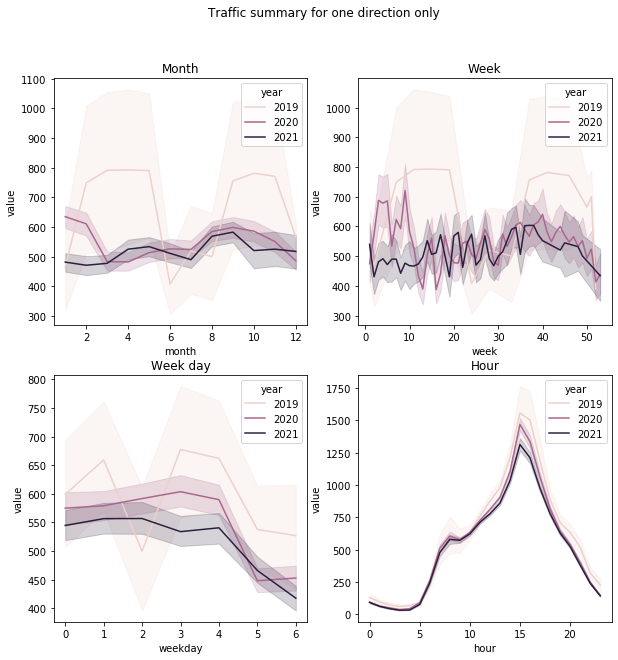

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
fig.suptitle('Traffic summary for one direction only')

sns.lineplot(ax=axes[0,0], x='month',y='value',hue='year',data=one_direction)
axes[0,0].set_title('Month')

sns.lineplot(ax=axes[0,1], x='week',y='value',hue='year',data=one_direction)
axes[0,1].set_title('Week')

sns.lineplot(ax=axes[1,0], x='weekday',y='value',hue='year',data=one_direction)
axes[1,0].set_title('Week day')

sns.lineplot(ax=axes[1,1], x='hour',y='value',hue='year',data=one_direction)
axes[1,1].set_title('Hour')


Text(0.5, 1.0, 'Hour')

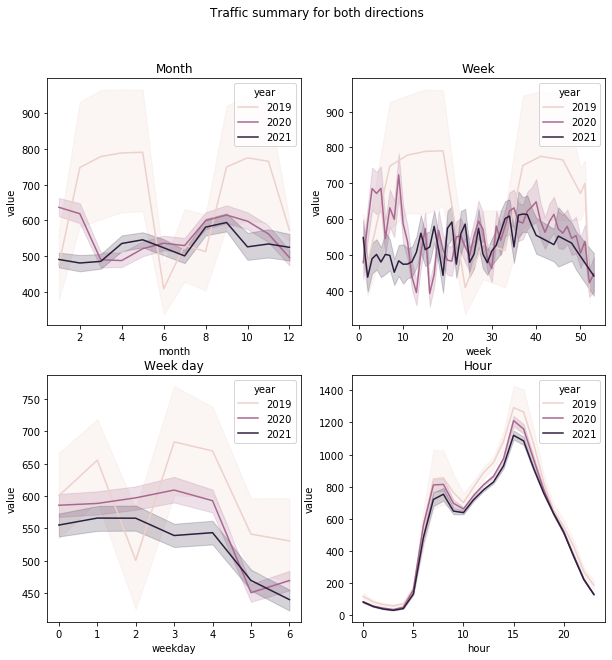

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
fig.suptitle('Traffic summary for both directions')

sns.lineplot(ax=axes[0,0], x='month',y='value',hue='year',data=data)
axes[0,0].set_title('Month')

sns.lineplot(ax=axes[0,1], x='week',y='value',hue='year',data=data)
axes[0,1].set_title('Week')

sns.lineplot(ax=axes[1,0], x='weekday',y='value',hue='year',data=data)
axes[1,0].set_title('Week day')

sns.lineplot(ax=axes[1,1], x='hour',y='value',hue='year',data=data)
axes[1,1].set_title('Hour')


As we can see different granularity in the scale gives us quite different results. Features such as the year, the month, the week of the year, the week day and the hour can have a big impact on the number of cars on the road.

Finally, let's look at the linear correlation between the variables in the data

In [20]:
data.corr()

,direction,hour,value,holiday,year,month,week,weekday,is_weekend,day
direction,1.000000e+00,4.229088e-19,0.018559,-2.590151e-17,4.362314e-15,3.076881e-15,3.278468e-15,1.597330e-17,-7.268383e-18,-1.390617e-16
hour,4.229088e-19,1.000000e+00,0.332316,1.311572e-16,1.728229e-15,-7.246952e-16,-5.191275e-16,5.229248e-17,5.523354e-17,4.284286e-17
value,1.855870e-02,3.323159e-01,1.000000,-1.360091e-01,-4.374395e-02,2.115749e-02,1.981546e-02,-9.454696e-02,-1.207118e-01,-6.321770e-03
holiday,-2.590151e-17,1.311572e-16,-0.136009,1.000000e+00,-1.977258e-02,-1.701887e-02,-1.251843e-03,7.521276e-01,9.344014e-01,-7.980233e-03
year,4.362314e-15,1.728229e-15,-0.043744,-1.977258e-02,1.000000e+00,-2.301712e-01,-2.153043e-01,-3.726599e-03,-3.650852e-03,-6.362583e-02
month,3.076881e-15,-7.246952e-16,0.021157,-1.701887e-02,-2.301712e-01,1.000000e+00,9.535986e-01,-1.802986e-02,-1.678534e-02,-3.421480e-02
week,3.278468e-15,-5.191275e-16,0.019815,-1.251843e-03,-2.153043e-01,9.535986e-01,1.000000e+00,-7.709196e-03,-1.093841e-02,1.087268e-02
weekday,1.597330e-17,5.229248e-17,-0.094547,7.521276e-01,-3.726599e-03,-1.802986e-02,-7.709196e-03,1.000000e+00,7.893797e-01,2.807189e-03
is_weekend,-7.268383e-18,5.523354e-17,-0.120712,9.344014e-01,-3.650852e-03,-1.678534e-02,-1.093841e-02,7.893797e-01,1.000000e+00,7.825509e-03
day,-1.390617e-16,4.284286e-17,-0.006322,-7.980233e-03,-6.362583e-02,-3.421480e-02,1.087268e-02,2.807189e-03,7.825509e-03,1.000000e+00


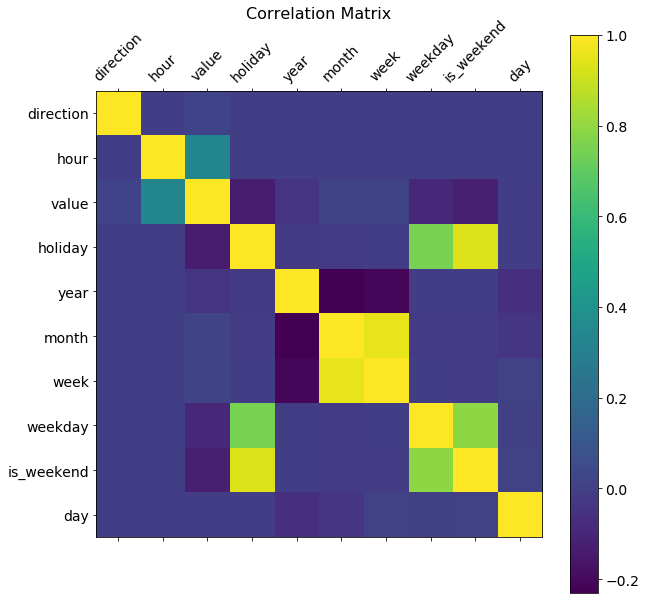

In [21]:
f = plt.figure(figsize=(10, 10))

plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16, pad=50);

The highest correlation is between month and week. This is because the more weeks pass, the more months pass.
The negative correlation between year and month and week is also irrelevant since it has to do with how time works.

What matters most is what is correlated with the value of cars on the road:
* The hour of the day shows a high positive correlation,
* Being a holiday shows a negative correlation,
* The day of the week and the weekend also show a negative correlation.
The day of the week and the weekend are very correlated as is expected.
The weekend is almost 100% correlated with the holiday because all weekends are marked as holidays.

## Modelling


Now that we have a good picture of the data, let's start to see if we can find a good fit.

It's important to note that since we are dealing with time series data, we can not blindly form train and test splits randomly.
We have to respect the structure of the data and only test on future samples.

In [22]:
# Let's divide the data into input features (X) and target features (y)
input_features = ['direction', 'hour', 'holiday', 'year', 'month', 'week', 'weekday', 'day', 'is_weekend']
target_feature = ['value']
X = np.array(data[input_features])
y = np.array(data[target_feature])
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (32160, 9)
Shape of y: (32160, 1)


In [23]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [   0    1    2 ... 5357 5358 5359] TEST: [ 5360  5361  5362 ... 10717 10718 10719]
TRAIN: [    0     1     2 ... 10717 10718 10719] TEST: [10720 10721 10722 ... 16077 16078 16079]
TRAIN: [    0     1     2 ... 16077 16078 16079] TEST: [16080 16081 16082 ... 21437 21438 21439]
TRAIN: [    0     1     2 ... 21437 21438 21439] TEST: [21440 21441 21442 ... 26797 26798 26799]
TRAIN: [    0     1     2 ... 26797 26798 26799] TEST: [26800 26801 26802 ... 32157 32158 32159]


As we can see `TimeSeriesSplit` respects the direction of time and does not leak data into the test set.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_train = []
mae_percentage = []
for train_index, test_index in tscv.split(X):
    # Get the train and test data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # See model performance
    predictions_train = lin_reg.predict(X_train)
    predictions_test = lin_reg.predict(X_test)
    print("MAE (train) = ", mean_absolute_error(y_train, predictions_train))
    print("MAE (test) = ", mean_absolute_error(y_test, predictions_test))

MAE (train) =  375.25645156823384
MAE (test) =  319.808383983027
MAE (train) =  343.9743935524636
MAE (test) =  347.88643987819285
MAE (train) =  345.1829453737772
MAE (test) =  322.23723155798444
MAE (train) =  339.5280087692909
MAE (test) =  310.10266619752747
MAE (train) =  334.11886491135147
MAE (test) =  320.56505031681417


We need to use the negative mean absolute error because for cross validation scores in sklearn higher is always better.

In [25]:
lin_reg = LinearRegression()
cv_score_mae = cross_val_score(lin_reg, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_score_mape = cross_val_score(lin_reg, X, y, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv_score_r2 = cross_val_score(lin_reg, X, y, cv=tscv, scoring='r2', n_jobs=-1)

In [26]:
cv_score_mae, cv_score_mape, cv_score_r2, cv_score_r2.mean()

(array([-319.80838398, -347.88643988, -322.23723156, -310.1026662 ,
        -320.56505032]),
 array([-3.04776237, -2.17971458, -2.91738494, -2.44737318, -2.38843258]),
 array([0.08896215, 0.08991472, 0.12124327, 0.13060835, 0.13345494]),
 0.11283668857457108)

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
cv_score_mae = cross_val_score(rf_reg, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_score_mape = cross_val_score(rf_reg, X, y, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv_score_r2 = cross_val_score(rf_reg, X, y, cv=tscv, scoring='r2', n_jobs=-1)

In [28]:
cv_score_mae, cv_score_mape, cv_score_r2, cv_score_r2.mean()

(array([-137.80347948, -102.78242351, -135.83134142,  -90.65032836,
         -83.32282276]),
 array([-0.58934319, -0.30918833, -0.45712356, -0.25851947, -0.27229759]),
 array([0.69944813, 0.83436015, 0.71282842, 0.85110534, 0.8734659 ]),
 0.7942415879967818)

As we can see a random forest regressor can outperform without any hyperparameter tuning to a linear regression model. However, both models perform fairly good.

In [29]:
cv_score_mape = cross_val_score(rf_reg, X, y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

In [30]:
cv_score_r2 = cross_val_score(rf_reg, X, y, cv=tscv, scoring='r2', n_jobs=-1)
cv_score_r2

array([0.69779413, 0.82936263, 0.71300469, 0.85017612, 0.87502948])

In [31]:
cv_score_mape

array([-52498.58598558, -34271.33745707, -50641.04490933, -24963.05550151,
       -21876.05153336])

## Plotting the results


Now that we have a working model and we know it performs well ($R^2=0.87$ for the last split of the RF model), let's see how good these predictions look on plots.

`X_train` contains the last split so this is what we want to test.

In [32]:
X_train.shape, X_test.shape

((26800, 9), (5360, 9))

In [33]:
rf_reg.fit(X_train, y_train)

C:\Users\ansni\AppData\Local\Temp/ipykernel_8488/3901435218.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


RandomForestRegressor()

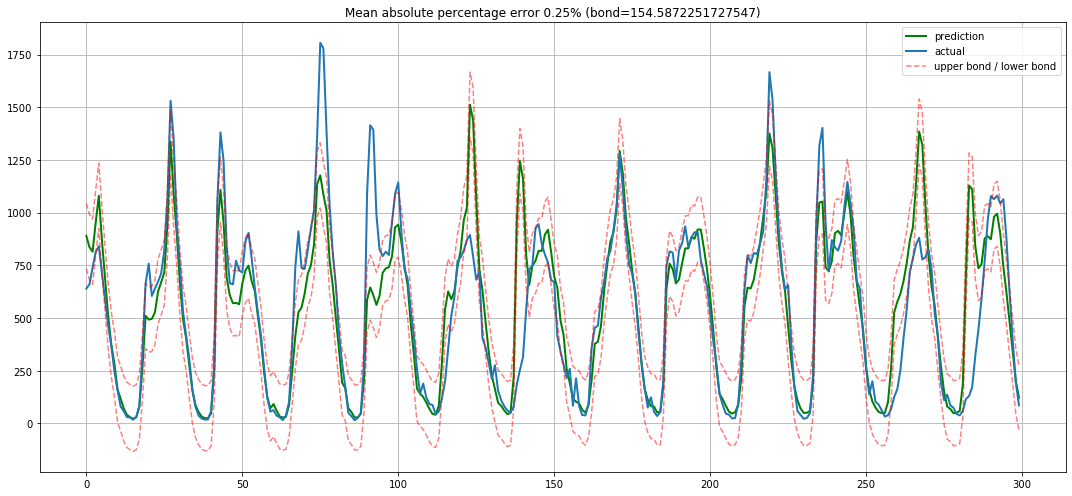

In [46]:
plotModelResults(rf_reg, X_train=X_train, X_test=X_test, y_test=y_test, size=300, cv=cv_score_mae, plot_intervals=True)

This plot shows the comparison between the actual value and the predicted one with some upper and lower bonds based on the standard deviation of the CV. The plot corresponds to roughly the last 12.5 days of the data set ($300 h/24 h/day=12.5 days$), you can see that there are 12 cycles/peaks and a half.

As you can see the model predicts the lower demand very well with little to no error, while the highest peaks are more often missed. I'd say that about half the days here are quite spot on and the other half are either decent or not great.
I don't know much about traffic, but I would assume that predicting the demand peaks is the most difficult task. While predicting the demand at night is very easy.

In [52]:
mae = cv_score_mae.mean() * (-1)
deviation = cv_score_mae.std()
scale = 1.96
print(f"The 97.5% lower and upper bounds are defined by mae + scale * deviation={np.round(mae + scale * deviation)}")


The 97.5% lower and upper bounds are defined by mae + scale * deviation=155.0



Let's look at the feature importance since we're already here.

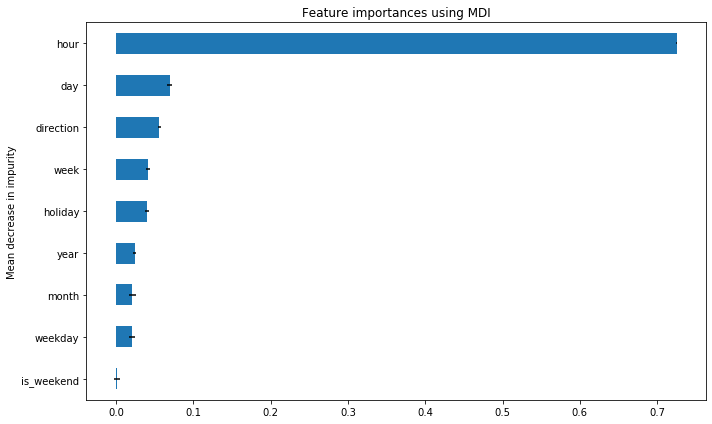

In [ ]:
plotCoefficients(rf_reg, input_features)

As you can see the variable representing the hour does most of the work. Other important ones, but far away, are the day of the month, the direction, the week of the year and whether it is a holiday.
The year, the month and the day of the week were somewhat a little relevant. Whether the day was a weekend or not did not carry any weight because the variable holiday already includes weekends.

## Save model to use in application

In [ ]:
pkl_filename = "forest_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_reg, file)

In [62]:
joblib.dump(rf_reg, "forest_model_compressed.pkl", 9) # compress model

['test.pkl']

The compressed model is 34MB.
The uncompressed one is 208MB, so this is a great reduction (6 fold). 

## Load model and predict as in application

Let's test how the model would be used in the dash app.

In [ ]:
model = joblib.load('./forest_model.pkl')
data_copy = pd.read_csv('clean_traffic.csv')

In [ ]:
# Input data
date = '23.10.2021'
time = '14'
direction = 0

In [ ]:
input_features

['direction',
 'hour',
 'holiday',
 'year',
 'month',
 'week',
 'weekday',
 'day',
 'is_weekend']

In [ ]:
time += ':00:00'
time = ' ' + time
time

' 14:00:00'

In [ ]:
timestamp = pd.to_datetime(date + time, infer_datetime_format=True)
timestamp

Timestamp('2021-10-23 14:00:00')

In [ ]:
direction = direction
hour = timestamp.hour
holiday = Finland().is_working_day(timestamp)
year = timestamp.year
month = timestamp.month
week = timestamp.week
weekday = timestamp.weekday()
day = timestamp.day
is_weekend = 1 if weekday in [5, 6] else 0

In [ ]:
prediction = model.predict(np.array([0, hour, holiday, year, month, week, weekday, day, is_weekend]).reshape(-1, 1).T)
prediction

array([1415.62])

In [ ]:
data_copy.head(1)

,Unnamed: 0,date,direction,hour,value,holiday,timestamp,year,month,week,weekday,is_weekend,day
0,0,2019-01-12,1,0,218,1,2019-01-12 00:00:00,2019,1,2,5,1,12


In [ ]:
data_copy.dtypes

Unnamed: 0     int64
date          object
direction      int64
hour           int64
value          int64
holiday        int64
timestamp     object
year           int64
month          int64
week           int64
weekday        int64
is_weekend     int64
day            int64
dtype: object

## Make plots for dash app
Let's create an interactive plot that will display the historic values for that selected day in the past for the 24 hours of the day (and both directions).

In [63]:
date = '2019-02-12'
px.line(data[data.date==date], x='hour', y='value', color='direction')

In [95]:
date_data

,date,direction,hour,value,holiday,timestamp,year,month,week,weekday,is_weekend,day
48,2019-02-12,outwards,0,76,0,2019-02-12 00:00:00,2019,2,7,1,0,12
49,2019-02-12,outwards,1,56,0,2019-02-12 01:00:00,2019,2,7,1,0,12
50,2019-02-12,outwards,2,31,0,2019-02-12 02:00:00,2019,2,7,1,0,12
51,2019-02-12,outwards,3,26,0,2019-02-12 03:00:00,2019,2,7,1,0,12
52,2019-02-12,outwards,4,42,0,2019-02-12 04:00:00,2019,2,7,1,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2020-02-12,2,19,546,0,2020-02-12 19:00:00,2020,2,7,2,0,12
3548,2020-02-12,2,20,413,0,2020-02-12 20:00:00,2020,2,7,2,0,12
3549,2020-02-12,2,21,251,0,2020-02-12 21:00:00,2020,2,7,2,0,12
3550,2020-02-12,2,22,121,0,2020-02-12 22:00:00,2020,2,7,2,0,12


In [96]:
date_input = '2019-02-12'
timestamp = pd.to_datetime(date_input)

date_data = data[(data.month == timestamp.month) & (data.day == timestamp.day)]
date_data.direction.replace([1, 2], ['Centre', 'Outskirts'], inplace=True)
fig = px.line(date_data, x='hour', y='value', color='year', line_dash='direction')
fig.show()

C:\Users\ansni\anaconda3\envs\IDS\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
data[(data.month == timestamp.month) & (data.day == timestamp.day)]

,date,direction,hour,value,holiday,timestamp,year,month,week,weekday,is_weekend,day
48,2019-02-12,1,0,76,0,2019-02-12 00:00:00,2019,2,7,1,0,12
49,2019-02-12,1,1,56,0,2019-02-12 01:00:00,2019,2,7,1,0,12
50,2019-02-12,1,2,31,0,2019-02-12 02:00:00,2019,2,7,1,0,12
51,2019-02-12,1,3,26,0,2019-02-12 03:00:00,2019,2,7,1,0,12
52,2019-02-12,1,4,42,0,2019-02-12 04:00:00,2019,2,7,1,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2020-02-12,2,19,546,0,2020-02-12 19:00:00,2020,2,7,2,0,12
3548,2020-02-12,2,20,413,0,2020-02-12 20:00:00,2020,2,7,2,0,12
3549,2020-02-12,2,21,251,0,2020-02-12 21:00:00,2020,2,7,2,0,12
3550,2020-02-12,2,22,121,0,2020-02-12 22:00:00,2020,2,7,2,0,12
